# Jacomo 7/15 Utah array GLMS/GQMs

In [4]:
import sys
sys.path.insert(0, './lib')

import os
import h5py 

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
import dill

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

Running on Computer: [ca1]
Save_dir = /home/dbutts/ColorV1/CLRworkspace/
cuda:1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load data (all stim)
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
num_lags=12

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16, 
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
104.1532871723175 sec elapsed
167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations


In [6]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
vallam = lam_units[a]
NCv = len(vallam)
print("%d out of %d units used"%(len(vallam), len(lam_units)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_cornerUT = matdat['top_corner'][:, 0]

adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=6,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_pars['device'] = device

data.set_cells(vallam)

# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']


21 out of 29 units used
Output set to 21 cells


In [7]:
vallam

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,
       129, 130, 131, 133, 134, 138, 139, 140])

In [8]:
top_corner_lam = [938, 515]

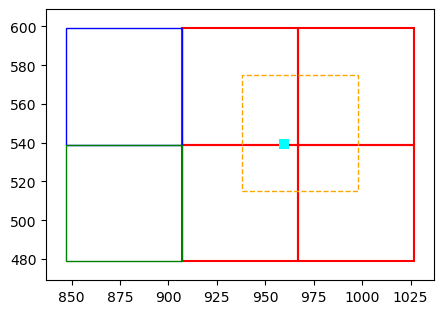

  Stim expansion for shift: [918, 495, 1018, 595]
  Writing lam stim 0: overlap 49, 44
  Writing lam stim 1: overlap 49, 56
  Writing lam stim 2: overlap 51, 56
  Writing lam stim 3: overlap 51, 44
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [9]:
# Make 60x60 STAs (and GLMs)
Xshift = 0 #8+4 
Yshift = 0 #-10+4
NX = 60

new_tc = np.array([top_corner_lam[0]-Xshift, top_corner_lam[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)

In [10]:
Reff = torch.mul(data.robs[:, vallam], data.dfs[:, vallam])
nspks = torch.sum(Reff, axis=0)
lag = 4
stas0 = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).numpy()

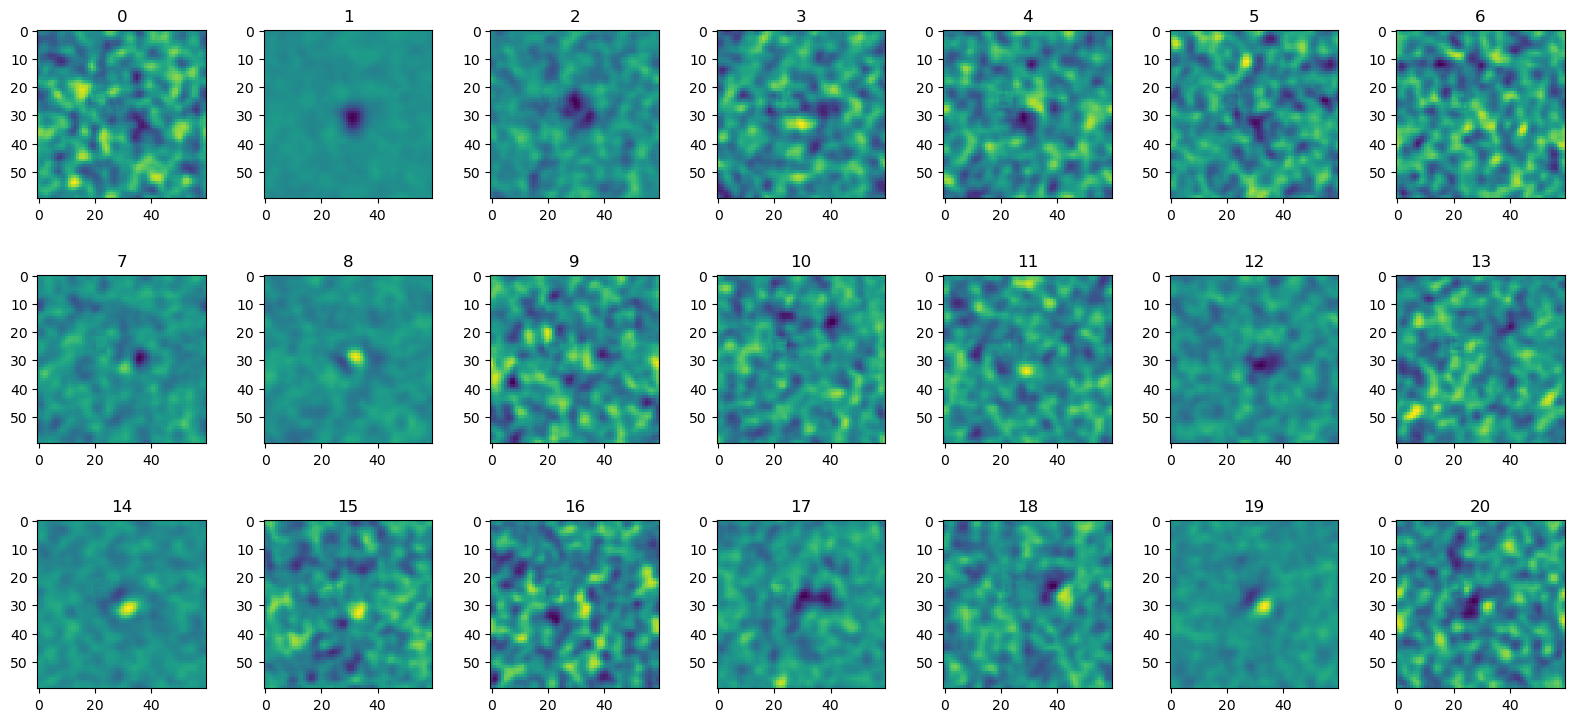

In [11]:
NCv = len(vallam)
ss(3,7)
for cc in range(NCv):
    plt.subplot(3,7, cc+1)
    imagesc(stas0[:,:, cc])
    plt.title(str(cc))
plt.show()

In [12]:
data.channel_map[vallam]

array([ 3, 13, 18, 19,  2,  4,  5,  8, 13, 22, 23, 19, 16,  3,  4,  5,  6,
        7, 22, 15,  3])

In [13]:
goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))

lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-8,
    tolerance_grad=1e-8,
    history_size=100,
    batch_size=20,
    max_epochs=3,
    max_iter = 500,
    device = device)

adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=5, num_workers=0,
    learning_rate=0.01, early_stopping_patience=10,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_parsT['device'] = device
adam_parsT['accumulated_grad_batches']=6

68.5% fixations remaining


# GLMs/GQMs

In [26]:
# GLM2 setup
data.add_covariate('stim2', abs(deepcopy(data.stim)))

In [27]:
data[1].keys()

--> 1 698


dict_keys(['stim', 'robs', 'dfs', 'fix_n', 'Xdrift', 'stim2'])

In [16]:
# GLM2 should be a inserted into the sequeence below and use the reg values optimized for stim
# It should have an extra network for stim2 (same params as the GLM layer)
stim_net2 =  FFnetwork.ffnet_dict( xstim_n='stim2', layer_list = [glm_layer] )
net_comb2 = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0,1,2],
                                 layer_list = [comb_layer], ffnet_type='add')
# and so on
glm2 = NDN.NDN(ffnet_list = [stim_net, stim_net2, drift_net, net_comb2], loss_type='poisson')

NameError: name 'glm_layer' is not defined

In [1]:
#set up fits
Treg = 1
Xreg = 20 # [20]
L1reg = 0.1 # [0.5]
GLreg = 10.0 # [4.0]

# drift network
drift_pars1 = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} } 
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# gqm net
num_subs = 2
gqm_layer = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=num_subs, num_inh=0, bias=False, num_lags=num_lags,
    NLtype='square', initialize_center = True)
gqm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 
stim_qnet =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [gqm_layer] )

#combine glm
comb_layer = ChannelLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

#combine gqm
comb2_layer = ChannelLayer.layer_dict( 
    num_filters = 1, NLtype='softplus', bias=False)
comb2_layer['weights_initializer'] = 'ones'

net2_comb = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0,1,2],
    layer_list = [comb2_layer], ffnet_type='normal')
net2_comb['layer_list'][0]['bias'] = True

glms = [None]*NCv
gqms = [None]*NCv
driftmods = [None]*NCv
X2opt = np.zeros([NCv,2])
T2opt = np.zeros([NCv,2])
GLopt = np.zeros([NCv,2])
L1opt = np.zeros([NCv,2])
LLsNULL = np.zeros(NCv)
LLsLR = np.zeros([NCv,4])
LLsQR = np.zeros([NCv,4])

rvals = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
rvalsG = [0.001, 0.1, 1, 10, 100, 1000] # glocal
rvalsL = [0.001, 0.01, 0.1, 1] # L1

NameError: name 'NDNLayer' is not defined

In [35]:
print(comb2_layer['input_dims'], comb2_layer['layer_type'])

None channel


input dims [1, 1, 1, 1]


AssertionError: ChannelLayer: Dim-0 of input must be non-trivial

In [30]:
NCv

21

Output set to 1 cells
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
GLM   0:  d2xt-R7   LLs = -0.005246639251708984
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
GLM   0:  Gloc-R5   LL = -0.005247 ->-0.001096
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
GLM   0:    L1-R3   LL = -0.001096 ->-0.000809


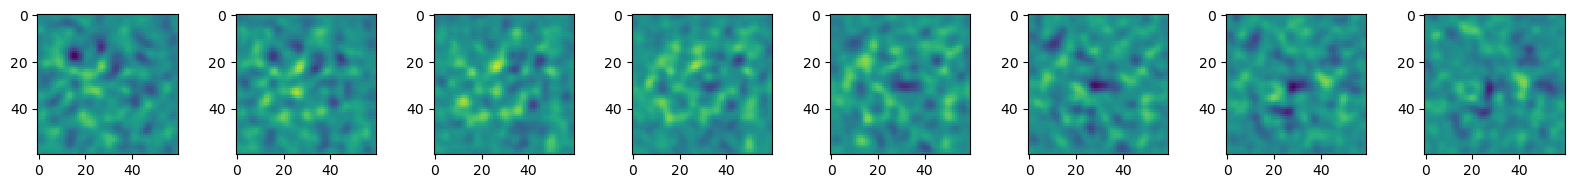

--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
GQM   0:  Gloc-R5   LL = -0.000809 ->-0.000839
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698
--> 0 698
--> 2 698
--> 2 698


KeyboardInterrupt: 

In [32]:
for cc in range(NCv):
    data.set_cells([vallam[cc]])
    
    # fit drift network
    drift_iter = NDN.NDN( 
        layer_list = [drift_pars1N], loss_type='poisson')
    drift_iter.block_sample=True
    drift_iter.networks[0].xstim_n = 'Xdrift'
    drift_iter.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
    LLsNULL[cc] = drift_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
    driftmods[cc] = deepcopy(drift_iter)
    
    # Fit GLM
    LLs = np.zeros(len(rvals)) + 1000
    for rr in range(len(rvals)):
        stim_net['layer_list'][0]['reg_vals']['d2xt'] = rvals[rr]
        glm_iter = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
        glm_iter.block_sample=True
        glm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
            driftmods[cc].networks[0].layers[0].weight.data[:,0])
        glm_iter.networks[1].layers[0].set_parameters(val=False)
        glm_iter.networks[2].layers[0].set_parameters(val=False,name='weight')

        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm0 = np.argmin(LLs)
    LLsLR[cc,0] = LLs[bm0]
    X2opt[cc, 0] = rvals[bm0]
    #glms[cc] = deepcopy(best_model)
    print( "GLM %3d:  d2xt-R%d   LLs ="%(cc, bm0), LLsNULL[cc]-LLsLR[cc,0] )

    #LLrunning = LLsNULL[cc]-LLsLR[cc,0]
    
    LLs = np.zeros(len(rvalsG))+LLsLR[cc,0]
    for rr in range(len(rvalsG)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm1 = np.argmin(LLs)
    if LLs[bm1] < LLsLR[cc,0]:
        LLsLR[cc,1] = LLs[bm1]
    else:
        LLsLR[cc,1] = LLsLR[cc,0]
        
    GLopt[cc,0] = rvalsG[bm1]
    #glms[cc] = deepcopy(best_model)
    print( "GLM %3d:  Gloc-R%d   LL = %9.6f ->%9.6f"%(cc, bm1, LLsNULL[cc]-LLsLR[cc,0], LLsNULL[cc]-LLsLR[cc,1]) )

    # L1 optimization
    LLs = np.zeros(len(rvalsL))+LLsLR[cc,1]
    for rr in range(len(rvalsL)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['l1'] = rvalsL[rr]
        #if bm2>1:
        #glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[bm2-1]
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm2 = np.argmin(LLs)
    if LLs[bm2] < LLsLR[cc,1]:
        LLsLR[cc,2] = LLs[bm2]
    else:
        LLsLR[cc,2] = LLsLR[cc,1]
        
    L1opt[cc,0] = rvalsL[bm2]

    glms[cc] = deepcopy(best_model)
    print( "GLM %3d:    L1-R%d   LL = %9.6f ->%9.6f"%(cc, bm2, LLsNULL[cc]-LLsLR[cc,1], LLsNULL[cc]-LLsLR[cc,2]) )
    best_glm = deepcopy(best_model)
    
    # Plot GLM filters
    #print( "Cell %3d: GLM"%(cc) )
    w = best_glm.get_weights()
    utils.subplot_setup(1,num_lags-4)
    for ll in range(num_lags-4):
        plt.subplot(1,num_lags-4,ll+1)
        utils.imagesc(w[:,:,ll+3,0], aspect=1, max=np.max(abs(w)))
    plt.show()
 
    #print("Now starting GQM fit")

    # now fit GQM
    LLs = np.zeros(len(rvals))+ 1000 #+LLsR[cc,0]
    LLsQR[cc,0] = LLsLR[cc,2]
    for rr in range(len(rvalsG)):
        gqm_iter = NDN.NDN(ffnet_list = [stim_net, drift_net, stim_qnet, net2_comb], loss_type='poisson')
        gqm_iter.networks[0].layers[0] = deepcopy(best_glm.networks[0].layers[0])
        gqm_iter.block_sample=True
        gqm_iter.networks[3].layers[0].set_parameters(val=False,name='weight')
        gqm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
            driftmods[cc].networks[0].layers[0].weight.data[:,0])
        gqm_iter.networks[1].layers[0].set_parameters(val=False)
        #gqm_iter.networks[0].layers[0].weight.data[:,0] = deepcopy(best_glm.networks[0].layers[0].weight.data[:,0])

        gqm_iter.networks[2].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi

    bmq1 = np.argmin(LLs)
    #if(LLs[bmq1-1]-LLs[bmq1]) < 0.01:
    #    bmq1 += -1
    LLsQR[cc,1] = LLs[bmq1]
    GLopt[cc,1] = rvals[bmq1]
    gqms[cc] = deepcopy(best_model)
    #print(LLs)
    print( "GQM %3d:  Gloc-R%d   LL = %9.6f ->%9.6f"%(cc, bmq1, LLsNULL[cc]-LLsLR[cc,2], LLsNULL[cc]-LLsQR[cc,1]) )

    LLs = np.zeros(len(rvals))+LLsQR[cc,1]
    for rr in range(len(rvals)):
        gqm_iter = deepcopy(best_model)
        gqm_iter.networks[2].layers[0].reg.vals['d2xt'] = rvals[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi
        
    bmq2 = np.argmin(LLs)
    if LLs[bmq2] < LLsQR[cc,1]:
        LLsQR[cc,2] = LLs[bmq2]
    else:
        LLsQR[cc,2] = LLsQR[cc,1]

    X2opt[cc,1] = rvals[bmq2]
    #gqms[cc] = deepcopy(best_model)
    #print(LLs)
    print( "GQM %3d:  d2xt-R%d   LL = %9.6f ->%9.6f"%(cc, bmq2, LLsNULL[cc]-LLsQR[cc,1], LLsNULL[cc]-LLsQR[cc,2]) )

    LLs = np.zeros(len(rvalsL))+LLsQR[cc,2]
    for rr in range(len(rvalsL)):
        gqm_iter = deepcopy(best_model)
        gqm_iter.networks[2].layers[0].reg.vals['l1'] = rvalsL[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi
        
    bmq3 = np.argmin(LLs)
    if LLs[bmq3] < LLsQR[cc,2]:
        LLsQR[cc,3] = LLs[bmq3]
    else:
        LLsQR[cc,3] = LLsQR[cc,2]
        
    L1opt[cc,1] = rvalsL[bmq3]
    
    gqms[cc] = deepcopy(best_model)
    #print(LLs)
    print( "GQM %3d:    L1-R%d   LL = %9.6f ->%9.6f"%(cc, bmq3, LLsNULL[cc]-LLsQR[cc,2], LLsNULL[cc]-LLsQR[cc,3]) )

    best_gqm = deepcopy(best_model)
    
    w2 = best_gqm.get_weights(ffnet_target=0).squeeze()
    w3 = best_gqm.get_weights(ffnet_target=2)

    maxall = np.maximum( np.max(abs(w2)), np.max(abs(w3)))
    utils.ss(3,num_lags-4, rh=2)
    for ll in range(num_lags-4):
        plt.subplot(3, num_lags-4, ll+1)
        utils.imagesc(w2[:,:, ll+3], aspect=1, max=maxall)
        for subs in range(2):
            plt.subplot(3, num_lags-4, ll+1+(num_lags-4)*(subs+1) )
            utils.imagesc(w3[:,:, ll+3, subs], aspect=1, max=maxall)
    plt.show()

In [17]:
dirname3 = dirname + 'J220715/models/'
dirname3

'/home/dbutts/ColorV1/CLRworkspace/J220715/models/'

In [29]:
## NEED TO SAVE THEM ALL(!)
Udrift_terms = np.zeros([NA, NCv])
for cc in range(NCv):
    Udrift_terms[:, cc] = driftmods[cc].get_weights()[:,0]
    glms[cc].save_model(alt_dirname=dirname3, filename='glmU'+utils.filename_num2str(cc, num_digits=3)+'.pkl')
    gqms[cc].save_model(alt_dirname=dirname3, filename='gqmU'+utils.filename_num2str(cc, num_digits=3)+'.pkl')

  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/glmU000.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/gqmU000.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/glmU001.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/gqmU001.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/glmU002.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/gqmU002.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/glmU003.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/gqmU003.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/glmU004.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/gqmU004.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/glmU005.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/J220715/models/gqmU005.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/

In [31]:
sio.savemat(dirname3+'LLinfo.mat', {'ULLsNULL': LLsNULL, 'Udrift_terms': Udrift_terms, 'Ucells': valET})

In [34]:
## PULL OUT RF centers
new_tc

array([920, 512])

In [38]:
cc = 173
kL = gqms[cc].networks[0].get_weights().squeeze()
kQ = gqms[cc].networks[2].get_weights()
kL.shape, kQ.shape
pfiltL = np.std(kL, axis=2)
pfiltQ = np.std(kQ, axis=2)
pfiltL.shape, pfiltQ.shape

((60, 60), (60, 60, 2))

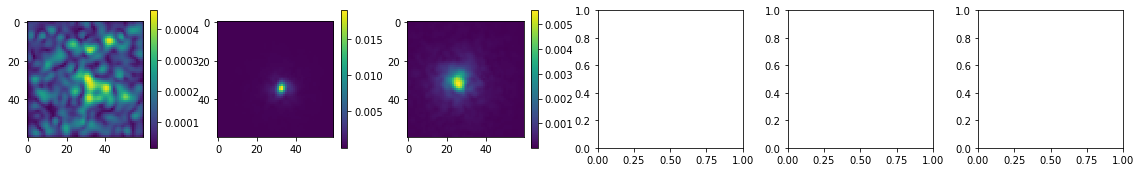

In [39]:
ss(1,6)
plt.subplot(161)
imagesc(pfiltL)
plt.colorbar()
for ii in range(2):
    plt.subplot(1,6,2+ii)
    imagesc(pfiltQ[:,:,ii])
    plt.colorbar()
plt.show()

In [ ]:
# Get array centers
RFcenters = np.zeros([NCv,2], dtype=np.int64) - 1
for cc in range(NCv):
    k = glms[cc].get_weights()
    # pfilt = np.sum(np.std(k, axis=3),axis=0).squeeze() # for colorRFs
    pfilt = np.std(k, axis=2).squeeze()
    x,y, snr = utils.RFstd_evaluate( pfilt )
    RFcenters[cc, :] = [x,y]

#for gg in range(2):
#    RFcenters[grps[gg], :] = shifts[[gg], :]

plt.plot(RFcenters[:, 0], RFcenters[:, 1],'o')
plt.show()